# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [125]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast;
from sklearn.preprocessing import StandardScaler;
from sklearn.preprocessing import Imputer;
from sklearn.decomposition import PCA;
from sklearn.cluster import KMeans;
import time;
from matplotlib.ticker import PercentFormatter
import pickle;

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [126]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';');

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';');

print(feat_info.head(5))

              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]


In [127]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape);
print(feat_info.shape);

(891221, 85)
(85, 4)


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [128]:
print(len(azdias[np.isnan(azdias['AGER_TYP'])]))
print(len(azdias[pd.isnull(azdias['AGER_TYP'])]))
print(len(azdias[azdias['AGER_TYP'] == -1]))

0
0
677503


In [129]:
# Identify missing or unknown data values and convert them to NaNs.

'''
The values array is in a stringified List, which can be parsed with ast, except for the case where there are
"X" values, so that is handled separately.
'''

for ix, row in enumerate(feat_info.iterrows()):
    attr_name = row[1]['attribute'];
    missing_key = row[1]['missing_or_unknown'];
    
    if 'XX' in missing_key or 'X' in missing_key:
        x_mis_values = missing_key.replace('[', '').replace(']', '').split(',');
        mis_values = [];
        for mis_val in x_mis_values:
            try:
                new_mis_val = int(mis_val);
            except ValueError:
                new_mis_val = mis_val;
            mis_values.append(new_mis_val);
    else:
        mis_values = ast.literal_eval(missing_key);
    
    for value in mis_values:
        #print(value, attr_name, len(azdias[azdias[attr_name] == value]))
        azdias[attr_name].replace(value, np.NaN, inplace=True);

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [130]:
'''
Number of NaN values are stored in a dictionary, which I put into a dictionary.
'''
col_nan_percentages = {};
for col in azdias:
    df_col = azdias[col];
    df_col_num_nan = len(df_col[pd.isnull(df_col)]);
    df_col_per_nan = 100 * (df_col_num_nan / len(df_col));
    
    col_nan_percentages[col] = df_col_per_nan;

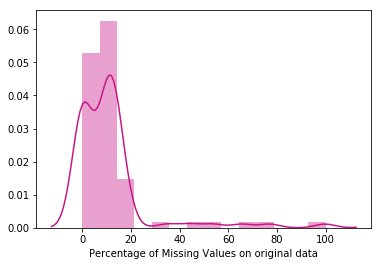

In [131]:
perc_values = pd.DataFrame.from_dict(col_nan_percentages, orient = 'index').reset_index();
perc_values.columns = ['Attribute Name', 'Percentage of Missing Values on original data'];

'''
I am going to look at a histogram of values.
'''

sns.distplot(perc_values['Percentage of Missing Values on original data'], bins=np.linspace(0,100,15), color='mediumvioletred');

In [132]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

'''
The histogram shows that 20% of columns have the most missing values. It shows that values above 8% stand out
more than all other columns. I am going to print the columns with most missing values.
'''

columns_with_missings = [];
print('Columns with more than 20% of values missing: ')
print();
for col in col_nan_percentages:
    if (col_nan_percentages[col] > 20):
        feat = feat_info[feat_info.attribute == col];
        print(col, feat['information_level'].item(), feat['type'].item(), col_nan_percentages[col]);
        print();
        columns_with_missings.append(col);

Columns with more than 20% of values missing: 

AGER_TYP person categorical 76.95543529607134

GEBURTSJAHR person numeric 44.02028228688507

TITEL_KZ person categorical 99.75763587258379

ALTER_HH household interval 34.81369940789097

KK_KUNDENTYP household categorical 65.59674873011295

KBA05_BAUMAX microcell_rr3 mixed 53.468668265222654



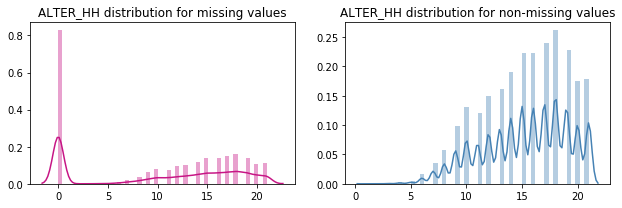

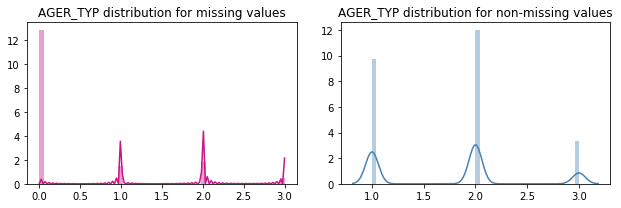

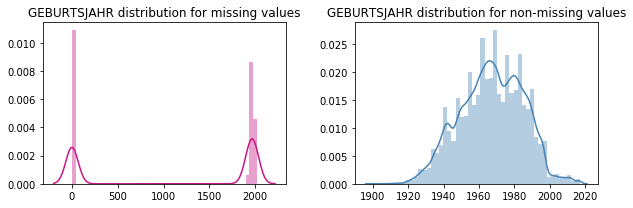

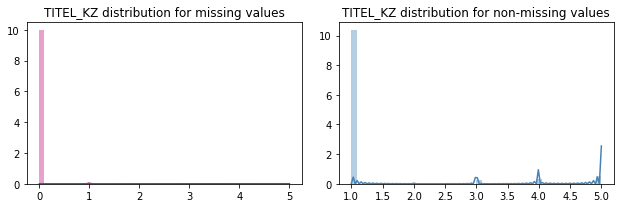

In [133]:
'''
Let's plot a few histograms on the distribution of some of the attributes in this list, which I can reference later
on the next discussion cell on the patterns of the features.
'''

for column in ['ALTER_HH', 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ']:
    plt.figure(figsize=(9,3));
    plt.subplot(1,2,1);
    graph = sns.distplot(pd.DataFrame(azdias[[column]].fillna(0)), hist=True, kde=True, color='mediumvioletred');
    plt.title(column + ' distribution for missing values');
    
    plt.subplot(1,2,2);
    graph = sns.distplot(pd.DataFrame(azdias[[column]].dropna()), hist=True, kde=True, color='steelblue');
    plt.title(column + ' distribution for non-missing values');
    plt.tight_layout();

Referencing these attributes from the "Feature Summary Dictionary" file, these attributes represent:

- **AGER_TYPE** : which age group the person is in
- **GEBURTSJAHR** : Year of Birth
- **TITEL_KZ** : Academic Title
- **ALTER__HH** : Birthdate of head of household
- **KK_KUNDENTYP** : Consumer pattern over the last 12 months
- **KBA05_BAUMAX** : Type of building type within the microcell

In [134]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

columns_with_missings.remove('GEBURTSJAHR')
azdias.drop(columns_with_missings, axis=1, inplace=True);

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Out of these, `KK_KUNDENTYP` is a very important feature because it represents exactly what we are trying to predict, but it has a large number of missing values (65%).

There are three "age" type attributes, `ALTER_HH`, `AGER_TYP`, `GEBURTSJAHR`. The above 3 histograms of age types show the distribution in these attributes. Out of these `ALTER_HH` has the fewest number of missing values (33%), but `GEBURSTJAHR` has a more normal distribution, while the others are more skewed. So, out of these, if we are to keep one age attribute, I think I'll keep `GEBURSTJAHR`.

`KBA05_BAUMAX` is a household type feature, and it can help identify the type of household the person is in. This is an important feature, but there are 65% missing values so it won't be very helpful.

`TITEL_KZ` is an outlier, with 99% missing values, so although it can be a useful person identifier, it won't contribute anything to the prediction. I showed a histogram above with its values, and it looks like it has a very skewed distribution.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?

'''
At different thresholds, the amount of total missing values is different.
'''
for thresh in range(10, 50, 5):
    print(thresh, len(azdias[azdias.isnull().sum(axis=1) > thresh]) / len(azdias))

10 0.12715476857030972
15 0.1124558330649749
20 0.10546991150343181
25 0.10467212958402013
30 0.10452850639740312
35 0.08714449053601744
40 0.08315670299510447
45 0.05169312662066985


In [35]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

'''
From this, I am going to use the threshold of 30 or more NaN values, to remove around 10% values.
'''
thresh = 30;
rows_with_empty = azdias[azdias.isnull().sum(axis=1) > thresh];
rows_wito_empty = azdias[azdias.isnull().sum(axis=1) <= thresh];

print('Rows > threshold : ' + str(len(rows_with_empty)));
print('Rows <= threshold : ' + str(len(rows_wito_empty)));

print();
print('Columns with little or no missing data:');
print();
for col in col_nan_percentages:
    if (col_nan_percentages[col] == 0):
        print(col);

Rows > threshold : 90651
Rows <= threshold : 800570

Columns with little or no missing data:

ANREDE_KZ
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GREEN_AVANTGARDE
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ZABEOTYP


Taking 6 of the columns from the above list which have no missing values


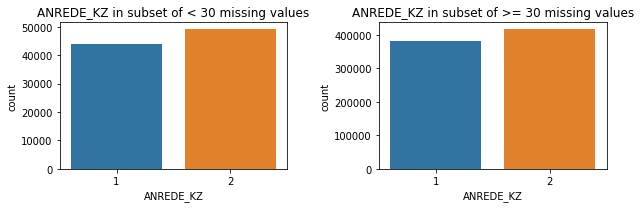

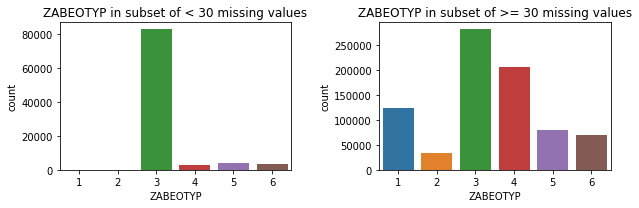

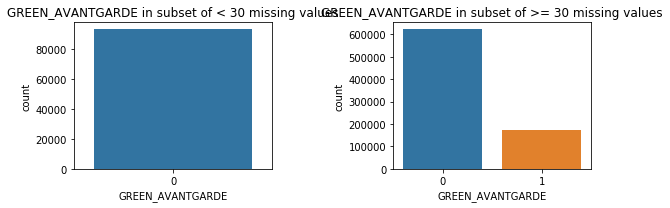

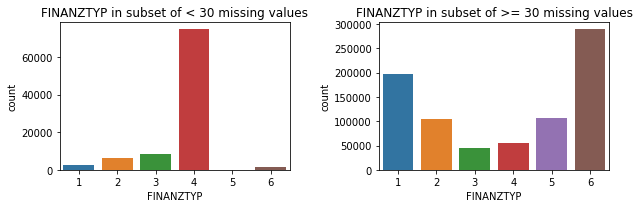

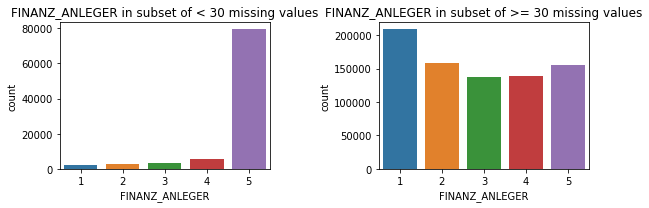

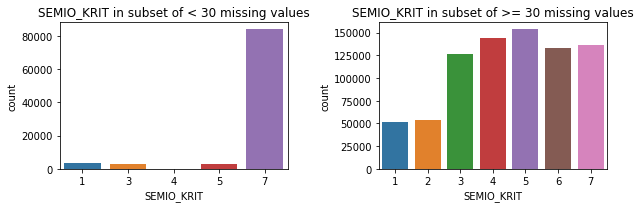

In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

print('Taking 6 of the columns from the above list which have no missing values');

for column in ['ANREDE_KZ', 'ZABEOTYP', 'GREEN_AVANTGARDE', 'FINANZTYP', 'FINANZ_ANLEGER', 'SEMIO_KRIT']:
    plt.figure(figsize=(9,3));
    plt.subplot(1,2,1);
    graph = sns.countplot(x=column, data=rows_with_empty);
    plt.title(column + ' in subset of < 30 missing values');
    
    plt.subplot(1,2,2);
    graph = sns.countplot(x=column, data=rows_wito_empty);
    plt.title(column + ' in subset of >= 30 missing values');
    plt.tight_layout();

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

**Yes**, *data with the missing data is very different from the data with less missing data. In the above 6 plots, we can see this with most of the features.*

- `ANREDE_KZ` (Gender) removed several values, but the overall distribution was the same
- `ZABEOTYP` (Energy consumption typology) removed thousands of values where the values was not "1.0".
- `GREEN_AVANTGRADE` (Memberhsip in environmental sustainability) removed all values were the value was not "0.0".
- `FINANZTYP` (Type of financial classification) removed values that were not "4.0" mostly, and the final distribution is much different than the original one.
- `FINANZ_ALEGER` (Financial typology) removed many values that were not "5.0"
- `SEMIO_KRIT` (Person typology) removed many values that were not "7.0"

*Out of all these, for many of them the distribution changed significantly for the attributes after values were removed, because one value was kept while all others were removed.*

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?

pd.DataFrame(feat_info.groupby('type').count()['attribute'])

,attribute
type,
categorical,21
interval,1
mixed,7
numeric,7
ordinal,49


In [11]:
'''
N Unique gives us the number of unique values for each attribute.
'''
nunique = azdias.nunique();

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [16]:
'''Let's find the attribute with the non-numeric binary values'''
for bin_var, bin_num in nunique[nunique == 2].iteritems():
    t_uniques = pd.unique(azdias[bin_var]);
    print(bin_var, t_uniques)

ANREDE_KZ [1 2]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ nan   1.   0.]
VERS_TYP [ nan   2.   1.]
OST_WEST_KZ [nan 'W' 'O']


In [12]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

'''
I will iterate through all features.

If it is binary, we keep them. The attribute `OST_WEST_KZ` (building location based on former East/West germany)
will be re-encoded because it is non-numerical.

If it is multi-level categorical, I will also re-encode them to dummy variables, rather than 
removing them (explanation below).
'''

new_columns_to_old_mapping = {};
for num in range(len(feat_info)):
    if (feat_info.iloc[num]['type'] == 'categorical'):
        attr_name = feat_info.iloc[num]['attribute'];
        if (attr_name in nunique):
            if (nunique[attr_name] != 2 or attr_name == 'OST_WEST_KZ'):
                dummy_mapping = pd.get_dummies(azdias[attr_name], prefix=attr_name);
                azdias = pd.concat([azdias, dummy_mapping], axis=1);
                azdias.drop([attr_name], axis=1, inplace=True);
                
                for col in dummy_mapping.columns:
                    new_columns_to_old_mapping[col] = attr_name;
            else:
                pass;

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

*I decided to keep all of the categorical attributes, and not remove them. I replaced these attributes with the
re-encoded dummy attributes. I decided to do this based on the analysis above in which we selected 6 attributes
and plotted their distributions from values with NaN values kept, and NaN values removed.*

*Most of the graphs showed that removing rows resulted in very different distribtions, where the removed values
were thousands of values of all but one type. And these were only the attributes with more than 30% missing values.*

*The Engineering steps taken were adding Dummy Variables for the categorical types (and `OST_WEST_KZ`) like `OST_WEST_KZ_W` and `OST_WEST_KZ_O`, while removing the original one. If the attribute is binary, they are kept.*

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [13]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

praegende_jugendjahre_mapping = {1.0 : 40, 2.0 : 40, 3.0 : 50, 4.0 : 50, 5.0 : 60, 6.0 : 60, 7.0 : 60, 8.0 : 70,
                               9.0 : 70, 10.0 : 80, 11.0 : 80, 12.0 : 80, 13.0 : 80, 14.0 : 90, 15.0 : 90};

''' '0' for mainstream and '1' for avantgarde'''
praegende_jugendjahre_mapping_2 = {1.0 : 0, 3.0 : 0, 5.0 : 0, 8.0 : 0,
                                  10.0 : 0, 12.0 : 0, 14.0 : 0,
                                   2.0 : 1, 4.0 : 1, 6.0 : 1, 7.0 : 1,
                                   9.0 : 1, 11.0 : 1, 13.0 : 1, 15.0 : 1};

azdias = pd.concat([azdias, azdias['PRAEGENDE_JUGENDJAHRE'].map(praegende_jugendjahre_mapping).rename('pj_decade'), 
                    azdias['PRAEGENDE_JUGENDJAHRE'].map(praegende_jugendjahre_mapping_2).rename('pj_movement')], axis=1);
azdias.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True);

new_columns_to_old_mapping['pj_decade'] = 'PRAEGENDE_JUGENDJAHRE';
new_columns_to_old_mapping['pj_movement'] = 'PRAEGENDE_JUGENDJAHRE';

In [14]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

ci_wealth = azdias['CAMEO_INTL_2015'].map(lambda x: int(int(x) / 10) if not pd.isnull(x) else x).rename('ci_wealth');
ci_lifestyle = azdias['CAMEO_INTL_2015'].map(lambda x: int(x) % 10 if not pd.isnull(x) else x).rename('ci_lifestyle');
azdias = pd.concat([azdias, ci_wealth, ci_lifestyle], axis=1);
azdias.drop(['CAMEO_INTL_2015'], axis=1, inplace=True);

new_columns_to_old_mapping['ci_wealth'] = 'CAMEO_INTL_2015';
new_columns_to_old_mapping['ci_lifestyle'] = 'CAMEO_INTL_2015';

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

*I performed the encoding steps that were outlined above, and decided not to remove either. When we computed the attributes with a large number of missing values earlier, neither of these attributes had more than the 30% threshold.*

*For `PRAEGENDE_JUGENDJAHRE`, I used the "feature summary" document to create dictionaries of the current values to the actual movement and decade values. I then used a Pandas map to replace the existing values with values from the dictionaries.*

*For `CAMEO_INTL_2015`, I used Lambda functions to split the attribute by the Base 10, replacing the feature with Wealth and Lifestyle features.*

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [24]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

'''
Let's look at which new values were added, and which old values were removed.
'''
for col in azdias.columns:
    if col not in col_nan_percentages:
        print(col)

CJT_GESAMTTYP_1.0
CJT_GESAMTTYP_2.0
CJT_GESAMTTYP_3.0
CJT_GESAMTTYP_4.0
CJT_GESAMTTYP_5.0
CJT_GESAMTTYP_6.0
FINANZTYP_1
FINANZTYP_2
FINANZTYP_3
FINANZTYP_4
FINANZTYP_5
FINANZTYP_6
GFK_URLAUBERTYP_1.0
GFK_URLAUBERTYP_2.0
GFK_URLAUBERTYP_3.0
GFK_URLAUBERTYP_4.0
GFK_URLAUBERTYP_5.0
GFK_URLAUBERTYP_6.0
GFK_URLAUBERTYP_7.0
GFK_URLAUBERTYP_8.0
GFK_URLAUBERTYP_9.0
GFK_URLAUBERTYP_10.0
GFK_URLAUBERTYP_11.0
GFK_URLAUBERTYP_12.0
LP_FAMILIE_FEIN_1.0
LP_FAMILIE_FEIN_2.0
LP_FAMILIE_FEIN_3.0
LP_FAMILIE_FEIN_4.0
LP_FAMILIE_FEIN_5.0
LP_FAMILIE_FEIN_6.0
LP_FAMILIE_FEIN_7.0
LP_FAMILIE_FEIN_8.0
LP_FAMILIE_FEIN_9.0
LP_FAMILIE_FEIN_10.0
LP_FAMILIE_FEIN_11.0
LP_FAMILIE_GROB_1.0
LP_FAMILIE_GROB_2.0
LP_FAMILIE_GROB_3.0
LP_FAMILIE_GROB_4.0
LP_FAMILIE_GROB_5.0
LP_STATUS_FEIN_1.0
LP_STATUS_FEIN_2.0
LP_STATUS_FEIN_3.0
LP_STATUS_FEIN_4.0
LP_STATUS_FEIN_5.0
LP_STATUS_FEIN_6.0
LP_STATUS_FEIN_7.0
LP_STATUS_FEIN_8.0
LP_STATUS_FEIN_9.0
LP_STATUS_FEIN_10.0
LP_STATUS_GROB_1.0
LP_STATUS_GROB_2.0
LP_STATUS_GROB_3.0
LP_STAT

In [25]:
for col in col_nan_percentages:
    if col not in azdias.columns:
        print(col)

AGER_TYP
CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
PRAEGENDE_JUGENDJAHRE
SHOPPER_TYP
TITEL_KZ
ZABEOTYP
ALTER_HH
KK_KUNDENTYP
GEBAEUDETYP
OST_WEST_KZ
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015
KBA05_BAUMAX


In [26]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

'''
After manual inspection, the only difference between the old and new dataframes are the engineered features, and 
all of the existing values that were replaced were also removed.
'''

pass;

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [15]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';');
    
    for ix, row in enumerate(feat_info.iterrows()):
        attr_name = row[1]['attribute'];
        missing_key = row[1]['missing_or_unknown'];
    
        if 'XX' in missing_key or 'X' in missing_key:
            x_mis_values = missing_key.replace('[', '').replace(']', '').split(',');
            mis_values = [];
            for mis_val in x_mis_values:
                try:
                    new_mis_val = int(mis_val);
                except ValueError:
                    new_mis_val = mis_val;
                mis_values.append(new_mis_val);
        else:
            mis_values = ast.literal_eval(missing_key);

        for value in mis_values:
            #print(value, attr_name, len(df[df[attr_name] == value]))
            df[attr_name].replace(value, np.NaN, inplace=True);
    # remove selected columns and rows, ...
    t_columns_to_remove = ['AGER_TYP', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(t_columns_to_remove, axis=1, inplace=True);
    
    # select, re-encode, and engineer column values.
    t_columns_to_dummy = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN',
                          'LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP',
                          'ZABEOTYP','GEBAEUDETYP','OST_WEST_KZ','CAMEO_DEUG_2015','CAMEO_DEU_2015']
    
    for column in t_columns_to_dummy:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1);
        df.drop([column], axis=1, inplace=True);
    
    praegende_jugendjahre_mapping = {1.0 : 40, 2.0 : 40, 3.0 : 50, 4.0 : 50, 5.0 : 60, 6.0 : 60, 7.0 : 60, 8.0 : 70,
                               9.0 : 70, 10.0 : 80, 11.0 : 80, 12.0 : 80, 13.0 : 80, 14.0 : 90, 15.0 : 90};

    ''' '0' for movement and '1' for avantgarde'''
    praegende_jugendjahre_mapping_2 = {1.0 : 0, 3.0 : 0, 5.0 : 0, 8.0 : 0,
                                  10.0 : 0, 12.0 : 0, 14.0 : 0,
                                   2.0 : 1, 4.0 : 1, 6.0 : 1, 7.0 : 1,
                                   9.0 : 1, 11.0 : 1, 13.0 : 1, 15.0 : 1};

    df = pd.concat([df, df['PRAEGENDE_JUGENDJAHRE'].map(praegende_jugendjahre_mapping).rename('pj_decade'), 
                        df['PRAEGENDE_JUGENDJAHRE'].map(praegende_jugendjahre_mapping_2).rename('pj_movement')], axis=1);
    df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True);
    
    ci_wealth = df['CAMEO_INTL_2015'].map(lambda x: int(int(x) / 10) if not pd.isnull(x) else x).rename('ci_wealth');
    ci_lifestyle = df['CAMEO_INTL_2015'].map(lambda x: int(x) % 10 if not pd.isnull(x) else x).rename('ci_lifestyle');
    df = pd.concat([df, ci_wealth, ci_lifestyle], axis=1);
    df.drop(['CAMEO_INTL_2015'], axis=1, inplace=True);
    # Return the cleaned dataframe.
    
    return df;

In [16]:
'''
The clean_data function defined above uses the get_dummy method, which might return a different set of columns on
training then it might on testing if not all of the values are the same.

This function will call the clean_data function and replace the missing columns back from training as filled 0 values,
as they should be.
'''
def clean_data_and_replace_columns(train_data, test_data):
    cleaned_test_data = clean_data(test_data);
    missing_columns = set(train_data.columns).difference(set(test_data.columns));
    
    for col in missing_columns:
        cleaned_test_data[col] = 0;
    
    cleaned_test_data = cleaned_test_data[train_data.columns];
    return cleaned_test_data;

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

Original Unmodified Dataset (top) vs New Re-engineered Dataset (bottom): 


Text(0.5,1,'Percentage of Missing Values on cleaned data')

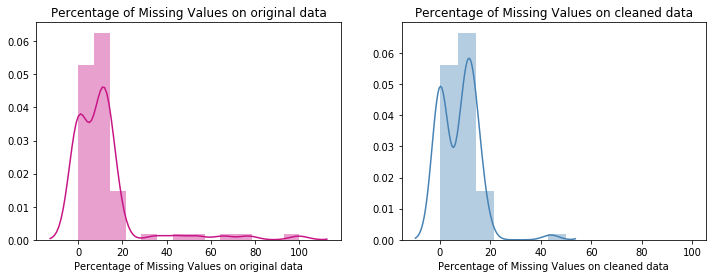

In [135]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

new_col_nan_percentages = {};
for col in azdias:
    df_col = azdias[col];
    df_col_num_nan = len(df_col[pd.isnull(df_col)]);
    df_col_per_nan = 100 * (df_col_num_nan / len(df_col));
    
    new_col_nan_percentages[col] = df_col_per_nan;
    
new_perc_values = pd.DataFrame.from_dict(new_col_nan_percentages, orient = 'index').reset_index();
new_perc_values.columns = ['Attribute Name', 'Percentage of Missing Values on cleaned data'];

print('Original Unmodified Dataset (top) vs New Re-engineered Dataset (bottom): ');

plt.figure(figsize=(12,4));
plt.subplot(1,2,1);
sns.distplot(perc_values['Percentage of Missing Values on original data'], bins=np.linspace(0,100,15), color='mediumvioletred');
plt.title('Percentage of Missing Values on original data')
plt.subplot(1,2,2);
sns.distplot(new_perc_values['Percentage of Missing Values on cleaned data'], bins=np.linspace(0,100,15), color='steelblue');
plt.title('Percentage of Missing Values on cleaned data')

In [17]:
'''
Using a SkLearn Imputer to replace all missing values with the mean (discussion below).
'''

imputer = Imputer();
azdias_imputed = imputer.fit_transform(azdias);
azdias_imputed = pd.DataFrame(azdias_imputed, columns=azdias.columns);

In [18]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler(with_mean=True, with_std=True);
azdias_scaled = scaler.fit_transform(azdias_imputed);
azdias_scaled = pd.DataFrame(azdias_scaled, columns=azdias_imputed.columns);

In [24]:
azdias_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,pj_decade,pj_movement,ci_wealth,ci_lifestyle
count,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,...,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05
mean,-8.317109e-16,1.004638e-16,3.507983e-18,9.879756e-17,5.941247e-17,-3.310260e-17,3.897050e-17,1.505562e-16,-1.997538e-14,9.583171e-18,...,3.098187e-17,5.265163e-17,-1.328250e-17,5.205767e-17,-6.454689e-17,5.995462e-18,3.438397e-15,-1.104377e-16,2.623174e-16,4.904638e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.742724e+00,-1.045218e+00,-1.570358e+00,-1.243244e+00,-1.816084e+00,-1.329319e+00,-1.260597e+00,-1.533438e+00,-5.039900e+00,-4.947009e-01,...,-1.418380e-01,-1.536004e-01,-1.790231e-01,-1.698398e-01,-1.820615e-01,-8.490699e-02,-2.436499e+00,-5.727990e-01,-1.638664e+00,-1.338297e+00
25%,-7.509715e-01,-1.045218e+00,-8.133868e-01,-1.243244e+00,-3.033778e-01,-6.755539e-01,-5.879796e-01,-7.944745e-01,-1.579273e-01,-4.947009e-01,...,-1.418380e-01,-1.536004e-01,-1.790231e-01,-1.698398e-01,-1.820615e-01,-8.490699e-02,-2.433020e-01,-5.727990e-01,-9.142640e-01,-1.338297e+00
50%,2.407808e-01,9.567382e-01,-5.641562e-02,1.221788e-01,-3.033778e-01,-2.178896e-02,8.463740e-02,-5.551131e-02,-1.707742e-14,-4.947009e-01,...,-1.418380e-01,-1.536004e-01,-1.790231e-01,-1.698398e-01,-1.820615e-01,-8.490699e-02,3.116720e-15,-5.727990e-01,3.216984e-16,9.071870e-02
75%,1.232533e+00,9.567382e-01,7.005556e-01,8.048901e-01,1.209329e+00,1.285741e+00,7.572544e-01,6.834519e-01,2.176091e-01,-4.947009e-01,...,-1.418380e-01,-1.536004e-01,-1.790231e-01,-1.698398e-01,-1.820615e-01,-8.490699e-02,1.218829e+00,-1.420953e-16,1.258937e+00,8.052265e-01
max,1.232533e+00,9.567382e-01,1.457527e+00,1.487601e+00,1.209329e+00,1.285741e+00,1.429871e+00,1.422415e+00,3.747651e+00,2.021423e+00,...,7.050298e+00,6.510400e+00,5.585870e+00,5.887902e+00,5.492650e+00,1.177759e+01,1.218829e+00,1.986963e+00,1.258937e+00,1.519734e+00


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

*For Feature Scaling, I decided to use an Imputer to replace all missing values with the mean accross that column.
From our observations earlier, removing missing NaNs skewed the distribution of columns significantly, with many
columns losing data points for more than one value. I could have removed all NaNs just for scaling, but that would
have given us a different mean and std than what would be correct for the rest of the dataset without missing values.*

*Because we already dropped the columns that had more than 15% missing values, this procedure will not change the overall distribution of the features, and we will still have all of the remaining data points from the dataset.*

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [116]:
# Apply PCA to the data.

'''Keeping all componenets'''
pca = PCA();
azdias_pca = pca.fit_transform(azdias_scaled);

In [141]:
# Investigate the variance accounted for by each principal component.
'''Functin copied from Lesson on Unsupervised Learning'''
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals, color='mediumvioletred')
    ax.plot(ind, cumvals, color='mediumvioletred')
    #for i in range(num_components):
        #ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

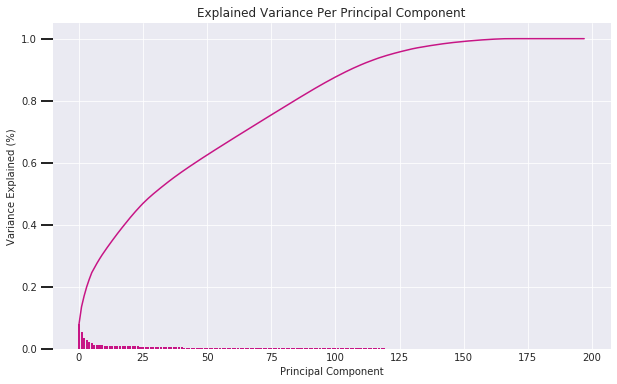

In [142]:
scree_plot(pca)

In [35]:
'''Detailed Values from 100 to 150'''
for comp in range(100, 160, 10):
    print(comp, np.cumsum(pca.explained_variance_ratio_)[comp]);

100 0.876510151636
110 0.916043731785
120 0.945972475917
130 0.967304826203
140 0.981326979244
150 0.991110432958


In [19]:
# Re-apply PCA to the data while selecting for number of components to retain.
'''Shown above, we get 95% explained variance with 120 components, so I will chose that.'''
pca_120 = PCA(n_components=120);
azdias_pca = pca_120.fit_transform(azdias_scaled);

In [20]:
pickle.dump(pca_120, open('pcl_120.pkl', 'wb'));
pickle.dump(azdias_pca, open('azdias_pca.pkl', 'wb'));

In [19]:
pca_120 = pickle.load(open('pcl_120.pkl', 'rb'))
azdias_pca = pickle.load(open('azdias_pca.pkl', 'rb'));

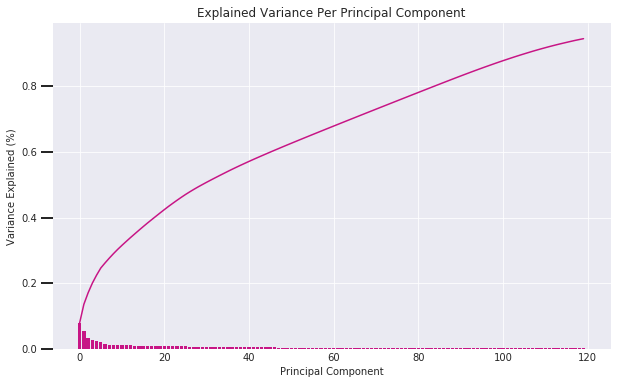

In [143]:
scree_plot(pca_120);

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

*I decided to use 120 Principal Componenets, which explain 95% of total explained variance. After testing with an initial fit on all components, I found that it takes around 75-100 componenets to get more than 80% explained variance, and 110 for 90%. 120 components are still 60% of all avalaible features, so it is still a significant reduction in the dimensionality.*

*Actual results from clustering will show us if we need to increase the number of components, which can be done if needed, for instance to 150 which covers 99% explained variance.*

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [53]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

azdias_component_analysis = pd.DataFrame(pca_120.components_, columns=azdias_scaled.columns);

def get_features_by_pc_weights(pc_num):
    first_principal_component = azdias_component_analysis.iloc[pc_num];
    first_principal_component_sorted = first_principal_component.sort_values(ascending=False)
    return first_principal_component_sorted;

In [39]:
'''Printing the most important features for the first Principal Component'''
first_pc_weights = get_features_by_pc_weights(0);
print(first_pc_weights[0:20])
print()
print(first_pc_weights[-20:])

LP_STATUS_GROB_1.0     0.182716
PLZ8_ANTG3             0.181624
ci_wealth              0.181151
PLZ8_ANTG4             0.176526
PLZ8_BAUMAX            0.172494
HH_EINKOMMEN_SCORE     0.160088
ORTSGR_KLS9            0.155264
EWDICHTE               0.153373
FINANZ_HAUSBAUER       0.144950
KBA05_ANTG4            0.125591
PLZ8_ANTG2             0.123819
LP_STATUS_FEIN_1.0     0.122653
ANZ_HAUSHALTE_AKTIV    0.113873
ARBEIT                 0.113696
KBA05_ANTG3            0.111908
CAMEO_DEUG_2015_9      0.109318
RELAT_AB               0.106489
LP_STATUS_FEIN_2.0     0.105545
FINANZ_SPARER          0.101968
FINANZTYP_1            0.100656
Name: 0, dtype: float64

ZABEOTYP_1            -0.094989
BALLRAUM              -0.096484
pj_movement           -0.096924
GEBAEUDETYP_RASTER    -0.097065
GREEN_AVANTGARDE      -0.099071
LP_STATUS_FEIN_9.0    -0.106662
ci_lifestyle          -0.106705
LP_STATUS_GROB_4.0    -0.108325
LP_STATUS_GROB_5.0    -0.108523
LP_STATUS_FEIN_10.0   -0.108523
LP_LEBENSPHASE_

In [40]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

'''Printing the most important features for the second Principal Component'''
second_pc_weights = get_features_by_pc_weights(1); 
print(second_pc_weights[0:20])
print()
print(second_pc_weights[-20:])

ALTERSKATEGORIE_GROB    0.229695
FINANZ_VORSORGER        0.225441
SEMIO_ERL               0.172430
RETOURTYP_BK_S          0.157566
ZABEOTYP_3              0.155356
SEMIO_LUST              0.154537
W_KEIT_KIND_HH          0.130105
CJT_GESAMTTYP_2.0       0.110016
FINANZTYP_5             0.107804
FINANZ_MINIMALIST       0.103850
FINANZTYP_2             0.101543
LP_STATUS_FEIN_1.0      0.094618
NATIONALITAET_KZ_1.0    0.090345
FINANZTYP_6             0.077337
SHOPPER_TYP_3.0         0.075778
FINANZ_HAUSBAUER        0.075304
CJT_GESAMTTYP_1.0       0.074168
LP_FAMILIE_FEIN_1.0     0.070015
LP_FAMILIE_GROB_1.0     0.070015
GFK_URLAUBERTYP_4.0     0.060662
Name: 1, dtype: float64

GFK_URLAUBERTYP_9.0     -0.069213
LP_STATUS_FEIN_5.0      -0.089023
ZABEOTYP_5              -0.090046
LP_STATUS_FEIN_2.0      -0.093903
ZABEOTYP_4              -0.094093
FINANZTYP_4             -0.101336
FINANZTYP_1             -0.127719
SEMIO_FAM               -0.127852
SEMIO_MAT               -0.130860
SEMIO_KUL

In [41]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

'''Printing the most important features for the third Principal Component'''
third_pc_weights = get_features_by_pc_weights(2); 
print(third_pc_weights[0:20])
print()
print(third_pc_weights[-20:])

SEMIO_VERT              0.324915
SEMIO_KULT              0.279234
SEMIO_SOZ               0.277182
SEMIO_FAM               0.201365
SHOPPER_TYP_0.0         0.137084
ZABEOTYP_1              0.131486
FINANZTYP_5             0.112558
FINANZ_MINIMALIST       0.096633
NATIONALITAET_KZ_1.0    0.092696
GREEN_AVANTGARDE        0.086530
SHOPPER_TYP_1.0         0.084329
OST_WEST_KZ_W           0.081974
SEMIO_MAT               0.074059
pj_movement             0.060450
LP_STATUS_GROB_5.0      0.059365
LP_STATUS_FEIN_10.0     0.059365
SEMIO_REL               0.058865
ZABEOTYP_6              0.056024
CJT_GESAMTTYP_4.0       0.049095
ORTSGR_KLS9             0.049025
Name: 2, dtype: float64

SHOPPER_TYP_3.0         -0.038673
FINANZ_SPARER           -0.041008
INNENSTADT              -0.043147
SHOPPER_TYP_2.0         -0.048879
LP_STATUS_FEIN_4.0      -0.060004
FINANZ_HAUSBAUER        -0.068830
FINANZ_UNAUFFAELLIGER   -0.073266
GFK_URLAUBERTYP_5.0     -0.090652
CJT_GESAMTTYP_6.0       -0.093390
LP_STATUS

In [42]:
'''
To better understand how common these features are, I will gather the features in the Top+Bottom 40, and compute
an intersection among them. Since there are many categorical variables that we created by expanding dummy variables,
I will use a reverse dictionary to map them back to their original keys, and also print those.
'''
first_pc_40 = pd.concat([first_pc_weights[0:20] , first_pc_weights[-20:]]);
second_pc_40 = pd.concat([second_pc_weights[0:20] , second_pc_weights[-20:]]);
third_pc_40 = pd.concat([third_pc_weights[0:20] , third_pc_weights[-20:]]);

first_common_keys = set([new_columns_to_old_mapping[key] if key in new_columns_to_old_mapping else key for key in first_pc_40.keys()])
secon_common_keys = set([new_columns_to_old_mapping[key] if key in new_columns_to_old_mapping else key for key in second_pc_40.keys()])
third_common_keys = set([new_columns_to_old_mapping[key] if key in new_columns_to_old_mapping else key for key in third_pc_40.keys()])

common_pc_feats = set(first_pc_40.keys()).intersection(set(second_pc_40.keys())).intersection(third_pc_40.keys());

common_pc_keys = first_common_keys.intersection(secon_common_keys).intersection(third_common_keys);
for feat in common_pc_keys:
    print()
    print(feat)
    try:
        print('\t1: ' , first_pc_40.loc[feat], ' 2: ', second_pc_40.loc[feat], ' 3: ', third_pc_40.loc[feat])
    except:
        print('\tMulti-Categorical variable')


PRAEGENDE_JUGENDJAHRE
	Multi-Categorical variable

FINANZ_MINIMALIST
	1:  -0.180231914305  2:  0.103850160142  3:  0.0966333057599

LP_STATUS_FEIN
	Multi-Categorical variable

ZABEOTYP
	Multi-Categorical variable

FINANZTYP
	Multi-Categorical variable

FINANZ_SPARER
	1:  0.101967803644  2:  -0.23849876632  3:  -0.041008059669

FINANZ_HAUSBAUER
	1:  0.144949630998  2:  0.0753040929961  3:  -0.0688299086138


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

*I printed the top 20 and bottom 20 features for each componenet. For each of them, the most important (positive and negative) features were (and definitions by the data dictionary):*


1. **LP_STATUS_GROB_1.0** *(social status)* and **MOBI_REGIO** *(movement patterns)*


2. **ALTERSKATEGORIE_GROB** *(age based on name)* and **pj_decade** *(decade of movement for the person)*


3. **SEMIO_VERT** *(dreamful personality)* and **SEMIO_KAEM** *(combative personality)*


*For the first two Principal Componenets, we see that detailed information about the person is the most important, such as their social status, age. The third principal component is focused almost entirely on personality, with 8 of it's top 10 weighted features being from the type 'personality', but it also has `anrede_kz` (gender) in it, another detailed fact.*

*It is interesting to note that `pj_decade`, a feature we extracted is one of the more important ones. It makes sense that `anrede_kz` and `finanztyp`, although not the top 1, are also amongst the important features because neither of them have any missing values, along with a few other attributes in these lists.*

*I also did further analysis by finding which features are common in all three principal components. Although there were three numerical attributes, I think the multi-categorical variables are the more interesting ones. For instance, `FINANZTYP` is common in all three PCs, and shows that each PC considers a different type of person of financial status to be of importance, and the same with `LP_STATUS_FEIN`, the social status*.

For each principal componenet, let's look at the positive/negative correlation within their features (instead of just the top 1, I'll look at 2 each from the top/bottom 5 features).

*First Principal component* : This PC has `LP_STATUS_GROB` (family type) and `ci_wealth` (wealth) correlatted positively together, and negatively correlated with `MOBI_REGIO` (movement pattern) and `FINANZ_MINIMALIST` (low financial interest). This makes sense because wealth can be correlated by family type (smaller families could have more money than very large families), and people who move a lot wouldn't have as much savings, thus lower financial intersts. Also, the positive-negative correlation also makes sense becasue people who have more wealth would be inversely correlated with people who have less financial interst.

*Second Principal component*: This PC has `FINANZ_VORSORGER` (prepared financially) and `RETOURTYP_BK_S` (return type) correlatted positively together, and negatively correlated with `FINANZ_SPARER` (money-savers) and `SEMIO_REL` (religious people). People who are prepared financially are likely to have a higher return type as customers, and their correlation with other positive attributes also looks right, such as with `SEMIO_ERL` (event-prepared), and it is likely tht many data points would share these values. Negatively, people who save money correlate with religion people. This might make sense if people within these data points are not considerabely wealthy. The positive-negative correlation also makes sense because people who are prepared financially are opposite of people who spare more.

*Third principal component*; This PC has `SEMIO_KULT` (culturally minded) and `SEMIO_FAM` (family minded) correlated positively, and negatively correlated with `SEMIO_KAEM` (combative mided) and `ANREDE_KZ` (gender). For this PC, many of the strongest weights are part of the same main feature (SEMIO), which is the personality. The positive correlations are all of people who are more conservative, such as being cultural and family-oriented, dreamful, and being social, all of these are among the top 5 positive weights, and they correlate negatively with people of opposite types, like the attribute KAEM shows, along with others like critically minded people and dominant minded. What was interesting is that Gender is also amont the important features for this component. It makes sense because men and women are likely to have different types of personality.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...
clusters = [];
scores = [];
for i in keep_awake(range(1)):
    for cluster_count in range(1, 30, 1):
        start = time.time();
        # run k-means clustering on the data and...
        kmeans_algo = KMeans(n_clusters=cluster_count).fit(azdias_pca);
        # compute the average within-cluster distances.
        kmeans_score = kmeans_algo.score(azdias_pca);
        clusters.append(cluster_count);
        scores.append(kmeans_score);
        print(cluster_count, kmeans_score, (time.time() - start) / 60.0);

In [148]:
'''The results from the above cell got over-written, but I saved their output to print them in a graph below.'''
clusters = np.arange(0,29);
scores = [-166473423.589,-156260073.119,-150828136.821,-147011196.587,-143882171.686,-141269835.347,-139705525.943,
-138357119.453,-137178440.736,-136121910.728,-134869092.674,-133784603.283,-132965401.297,-132213970.652,
-131696465.513,-130271239.242,-129479329.926,-129056846.517,-128834254.431,-127588662.938,-126810304.711,
-125627321.563,-125204018.573,-124418759.742,-123845848.813,-122837960.084,-121892154.77,-121189316.233,-121099187.27]

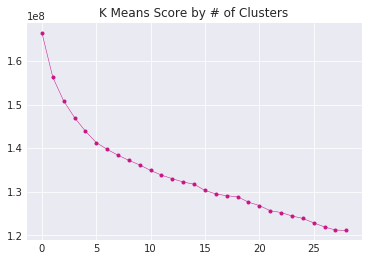

In [150]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters, np.abs(scores), 'r-', linewidth=0.5, marker='.', color='mediumvioletred');
plt.title('K Means Score by # of Clusters')
plt.show();

In [157]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

num_clusters_to_use = 17;
selected_kmeans_algo = KMeans(n_clusters=num_clusters_to_use, verbose=2).fit(azdias_pca);

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 141511554.509
start iteration
done sorting
end inner loop
Iteration 1, inertia 135251653.442
start iteration
done sorting
end inner loop
Iteration 2, inertia 133322195.212
start iteration
done sorting
end inner loop
Iteration 3, inertia 132497892.79
start iteration
done sorting
end inner loop
Iteration 4, inertia 132172912.087
start iteration
done sorting
end inner loop
Iteration 5, inertia 131935547.04
start iteration
done sorting
end inner loop
Iteration 6, inertia 131611951.801
start iteration
done sorting
end inner loop
Iteration 7, inertia 131148475.893
start iteration
done sorting
end inner loop
Iteration 8, inertia 130915212.735
start iteration
done sorting
end inner loop
Iteration 9, inertia 130729492.321
start iteration
done sorting
end inner loop
Iteration 10, inertia 130594313.448
start iteration
done sorting
end inner loop
Iteration 11, inertia 130513210.172
start iteration
done sorting

In [158]:
pickle.dump(selected_kmeans_algo, open('selected_kmeans_algo.pkl', 'wb'))

In [25]:
selected_kmeans_algo = pickle.load(open('selected_kmeans_algo.pkl', 'rb'))

In [26]:
azdias_clusters = selected_kmeans_algo.predict(azdias_pca);

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

*I tested a range of cluster values between 1 and 30, as the graph shows above. For each clustering, I also obtained the score for it, and based on those results, I decided to use **17** as the final number of clusters. Between clustering 17 and clustering 18, the score increased, after going down consistently for the previous iterations, so 17 seems like the right choice. After clustering 17, the time taken for each clustering was also longer, so 17 is the right fit between scoring and time taken for computation.*

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [20]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [21]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_cleaned = clean_data_and_replace_columns(azdias, customers);
customers_imputed = pd.DataFrame(imputer.transform(customers_cleaned), columns = customers_cleaned.columns);
customers_scaled = pd.DataFrame(scaler.transform(customers_imputed), columns = customers_imputed.columns);
customers_pca120 = pca_120.transform(customers_scaled);

In [27]:
customers_clusters = selected_kmeans_algo.predict(customers_pca120);

In [26]:
customers_distributions = pd.DataFrame(pd.Series(customers_clusters).value_counts()).reset_index();
customers_distributions.sort_values(by='index', inplace=True)
customers_distributions.set_index('index', inplace=True);
customers_distributions

,0
index,
0,23774
2,8
4,3402
6,18789
7,1911
8,45928
10,23083
11,618
13,13783


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [27]:
def plot_frequency_of_cluster_distributions(cluster_assignments_list, titles, num_clusters):
    plt.figure(figsize=(12,4));

    for pos, assignments in enumerate(cluster_assignments_list):
        plt.subplot(1,2,pos+1);
        t_c_uniques, t_c_counts = np.unique(assignments, return_counts=True)
        t_c_total = np.sum(t_c_counts);
        t_c_counts = [100*(cust / t_c_total) for cust in t_c_counts];

        missing_values = set(np.arange(0,num_clusters)).difference(t_c_uniques);
        t_c_uniques = np.concatenate((t_c_uniques, list(missing_values)));
        t_c_counts = np.concatenate((t_c_counts, [0]*len(missing_values)));
        
        t_c_uniques = [int(x) for x in t_c_uniques];
        t_c_distribution = pd.DataFrame({'cluster' : t_c_uniques, 'percentage' : t_c_counts});
        t_c_distribution.sort_values(by='cluster', inplace=True);
        graph = sns.barplot(x='cluster', y='percentage', data=t_c_distribution);
        graph.yaxis.set_major_formatter(PercentFormatter())
        #graph.set_yticks([0,5,10,15,20,25,30]);
        #graph.set_xticks(np.arange(0,16))
        plt.title(titles[pos]);
    plt.tight_layout()

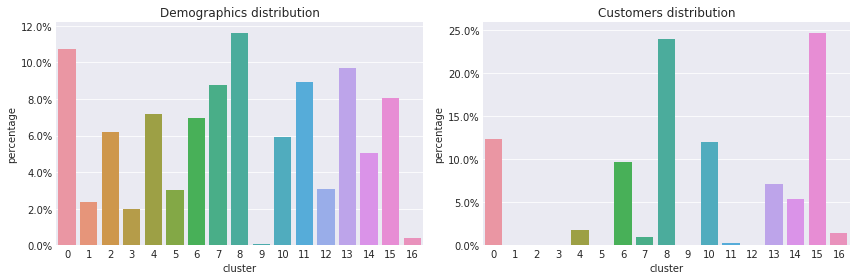

In [211]:
plot_frequency_of_cluster_distributions([azdias_clusters, customers_clusters], ['Demographics distribution', 'Customers distribution'], num_clusters_to_use)

In [28]:
pickle.dump(customers_pca120, open('customers_pca120.pkl', 'wb'));
pickle.dump(scaler, open('scaler.pkl', 'wb'));
pickle.dump(azdias, open('azdias.pkl', 'wb'));

In [13]:
customers_pca120 = pickle.load(open('customers_pca120.pkl', 'rb'));
scaler = pickle.load(open('scaler.pkl', 'rb'));
azdias = pickle.load(open('azdias.pkl', 'rb'));

In [79]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
'''
Cluster 15 is overrepresented in the customers data compared to demographics (25% vs 8%). Although it is high in both 
distributions, the average distribution of other clusters is much smaller. This is also true for Cluster 8, but
it is of the highest ratio in both so it is not overrepresented.

I will also look at Cluster 10 because the distribution in customers dataset is twice that of demographics (12% vs 6%).
This way, we can see how the important features for Cluster 15 are represented in a different cluster.
'''
customers_clusters_10 = customers_pca120[np.argwhere(customers_clusters == 8)];
customers_clusters_orig = pca_120.inverse_transform(customers_clusters_10);
customers_clusters_orig = scaler.inverse_transform(customers_clusters_orig);
clust_10_orig = pd.DataFrame(np.reshape(customers_clusters_orig, (customers_clusters_orig.shape[0], customers_clusters_orig.shape[2])), columns=azdias.columns);

customers_clusters_15 = customers_pca120[np.argwhere(customers_clusters == 15)];
customers_clusters_orig = pca_120.inverse_transform(customers_clusters_15);
customers_clusters_orig = scaler.inverse_transform(customers_clusters_orig);
clust_15_orig = pd.DataFrame(np.reshape(customers_clusters_orig, (customers_clusters_orig.shape[0], customers_clusters_orig.shape[2])), columns=azdias.columns);

In [80]:
'''Top 5 Principal Components for data points in Cluster 10'''
for i in range(0,10):
    print(np.argsort(-1*customers_clusters_10[i])[0][0:5])

[ 30   1   2  10 109]
[ 1 30  2 10 17]
[ 30  10  20 109   2]
[119  28 115   1  18]
[  2  31 109  30   1]
[ 17 114   7  45 119]
[  1  30   3 111 115]
[109  30 116 110 112]
[30 18 20 15 28]
[30 17  2 24 10]


In [30]:
'''Top 5 Principal Components for data points in Cluster 15'''
for i in range(0,10):
    print(np.argsort(-1*customers_clusters_15[i])[0][0:5])

[ 30 117  45  24  33]
[ 30 117  45  33  24]
[ 30 117  45  24  33]
[ 30 117  45  33  24]
[ 30 117  33  45 119]
[ 30 117  45  24  33]
[ 30 117  45  24  33]
[ 30 117  45  33  24]
[ 30 117  45  33  10]
[ 30 117  45  24  33]


We can already see the difference in the top Principal Components for Cluster `15` compared to Cluster `10`. In Cluster `10`, the Principal Components **1** and **2** are the more prominent ones, with PC **30** also showing up. Cluster `15` is really standardized, **30**, **45**, **24**, and **10** are the prominent componenets. **30** shows up in both clusters, but for Cluster `15` it is the Top 1.

We saw from earlier analysis that PCs **1** and **2** focus on family type, wealth, financial interst, and religion, among others. We can use the inverse-transformation to see which values are favored for Cluster 10. PCs **30** and **45**, on the other hand, focus on attributes like the neighborhood typology, relative unemployment status, vacation habits, consumer comsumption habits, and family type.

To compare the results, I will look at 4 features (non one-hot because I want to look at a larger range of values), and see what their distribution looks like in Clusters `15` and Cluster `10`. Because these features are part of the principal components that are part of Cluster 15, I expect that they will have more uniform values for it than for Cluster 10.

I will look at the features `ci_lifestyle`, `REGIOTYP`, `KKK`, and `BALLRAUM`.

In [31]:
#del azdias, azdias_clusters, azdias_imputed, azdias_pca, azdias_scaled, customers, customers_cleaned, customers_clusters_10
#del customers_clusters_15, customers_clusters_orig, customers_distributions, customers_imputed, customers_pca120

Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.

To look at how the different attributes influence the cluster assignments, I decided to use Box Plots to see what the range of values is for each feature. After performing inverse transformation on the PCA results, the results are not exact and instead soft values (such as being within 0 and 0.1 for off one-hot values). The Box Plot lets us see the overall distribution, as well as how values deviate from the mean.

Taking 4 of the columns where Cluster 10's Principal Components have higher weights


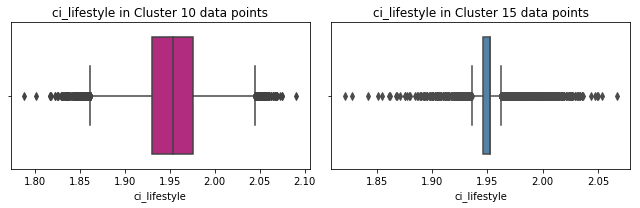

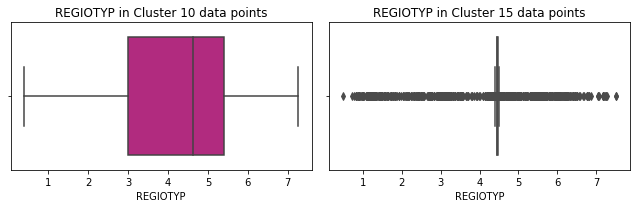

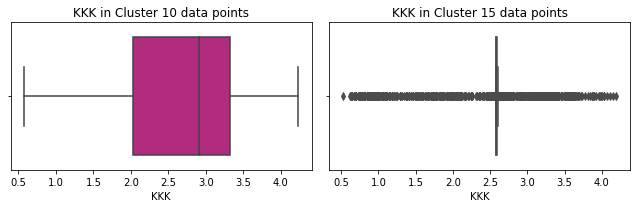

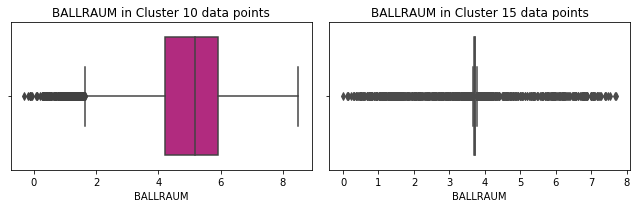

In [73]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

print('Taking 4 of the columns where Cluster 10\'s Principal Components have higher weights');

for column in ['ci_lifestyle','REGIOTYP','KKK','BALLRAUM']:
    plt.figure(figsize=(9,3));
    plt.subplot(1,2,1);
    graph = sns.boxplot(x=column, data=clust_10_orig, color='mediumvioletred');
    plt.title(column + ' in Cluster 10 data points');
    
    plt.subplot(1,2,2);
    graph = sns.boxplot(x=column, data=clust_15_orig, color='steelblue');
    plt.title(column + ' in Cluster 15 data points');
    plt.tight_layout();

Cluster **15** is the most over-represented cluster in the current assignments, and it's inclusion of 1st and 2nd Principal Components, the components that represent the largest explained variance after dimensionality reduction, show that it is able to get data points that that fit attributes within those components. 

I looked at 4 of the attributes that are represented by the principal components *1* and *2*, and for each of them, it is interesting to see that for each Box Plot, the values in Cluster **15** have a very small standard deviation from the mean. For cluster **10**, the standard deviation is actually really large, with the box plot adjacents really far distance from the box. Let's look at each attribute individually:

- `ci_lifestyle` : This is a generated variable describing the lifestage typology of the person. The average value for Cluster #15 is 1.95, which shows that in this cluster, the most common people are "Young Couples with Children". For Cluster #10, there are more data points that fall further from the mean of 1.95, so the attribute is not a primary classifier for the cluster.

- `REGIOTYP` : RegioTyp is the neighborhood typology. For Cluster #15, the mean is around 4.5, who are people who lie within "lower middle class" and "middle class". On the other hand, for Cluster #10, there are data points that are in range from 3 to 5.2, which also includes people in "upper middle class".

- `KKK` : The Purchasing Power in the region for the persons. The value for Cluster #15 lies between the classification "average" and "high", being closer to the first, showing that people in thie cluster live in regions with a little higher than average purchasing power. Again, for Cluster #10, the data points vary further from the mean.

- `BALLRAUM` - Distance to the nearest urban center. The average value for Cluster #15, 3.8 indicates that people in this cluster live around 30 KM to the nearest urban center. For Cluster #10, this average value is actually different, around 5.0, which are people who live around 50KM to the nearest urban center.

Putting all of these values together, we can see that Cluster 15 represents people who are generally in the middle class, have smaller families, younger, and live in mid-suburban regions. This makes sense as well because it is likely that people who fall in "middle class" are the largest ratio of people within the customer demographic, and thus represent 25% of the data points within the dataset. For Cluster 10, the same attributes are not the primary classifiers because the main principal components for it are different. However, these attributes show that people in Cluster 10 are more likely to be from the Upper Middle Class, whiile people in Cluster 15 are from Lower to Normal Middle class.

In [82]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

'''
Clusters 4 and 7 are underrepresented in the customers data compared to demographics (8% to 4% and 9% to 1%). There are
also several clusters which have no membership within the customers data, but they will not be possible to compare
because there are no data points for them.

I will look at both clusters, and will use attributes that are common between both of them to see how they are
represented by the clusters individually.
'''
customers_clusters_4 = customers_pca120[np.argwhere(customers_clusters == 4)];
customers_clusters_orig = pca_120.inverse_transform(customers_clusters_4);
customers_clusters_orig = scaler.inverse_transform(customers_clusters_orig);
clust_4_orig = pd.DataFrame(np.reshape(customers_clusters_orig, (customers_clusters_orig.shape[0], customers_clusters_orig.shape[2])), columns=azdias.columns);

customers_clusters_7 = customers_pca120[np.argwhere(customers_clusters == 7)];
customers_clusters_orig = pca_120.inverse_transform(customers_clusters_7);
customers_clusters_orig = scaler.inverse_transform(customers_clusters_orig);
clust_7_orig = pd.DataFrame(np.reshape(customers_clusters_orig, (customers_clusters_orig.shape[0], customers_clusters_orig.shape[2])), columns=azdias.columns);

In [108]:
'''Top 5 Principal Components for data points in Cluster 10'''
for i in range(0,20):
    print(np.argsort(-1*customers_clusters_4[i])[0][0:5])

[  2 115   3 114  30]
[30  2 28 45  7]
[  2  17  28 109  20]
[  2 114   3   6  24]
[114  27  22   7 111]
[  2  17  24  10 114]
[ 2 30 36 20 42]
[  2 114  30 110  19]
[  2  24 114  22  17]
[ 2  0 99 32 22]
[10 30  2 17 20]
[  2  24 116  22  42]
[  2  17  24 116  30]
[ 2 30 31 28  6]
[  2   3 114  30  24]
[ 2 30 36 24 42]
[ 30   2  17 117  37]
[ 31 106  19  30   3]
[  2 114  42  30  21]
[ 2 27 22 30 45]


In [109]:
'''Top 5 Principal Components for data points in Cluster 10'''
for i in range(0,20):
    print(np.argsort(-1*customers_clusters_7[i])[0][0:5])

[ 24  30 119 101  17]
[ 3 27 30  7 22]
[ 30  17  24 101  38]
[110 116  45  33 115]
[110 113  30 109 111]
[  0  45  27  33 117]
[ 11  31  30 119  24]
[ 3 28 30  6  7]
[ 24  31 113 109  30]
[ 24  30  31 117  17]
[  0 116  23  30 117]
[ 17  30  24  10 110]
[115  22  24   6 110]
[112  22   7  17  30]
[  4  25  30  22 110]
[ 17   0  33  45 110]
[  4  24   6 110  31]
[ 17 119  30 109 116]
[  3  30   7 112 110]
[ 17 116   3  38 114]


Compared to the previous clusters in the earlier analysis, the trends here are much different. There are no dominant Principal Components in all data points, but there are some common PCs. This includes components `24`, `30`, and `110` for Cluster #7 and `2`, `24`, and `114` for Cluster #4. 

We know from the analysis done earlier that Principal Component 2 focuses on financial status and religion, and from the previous discussion that component 30 on lifestyle and social status. Component 24 focuses instead on lifestyle and health. 

To compare the results between the two clusters, I will look at 4 features (also non-one hot because I want to look at a larger range of values), and compare their values between them. Clusters #4 and #7 should have different distributions and average values that represent different types of customers.

I will look at the features `FINANZ_HAUSBAUER`, `ANREDE_KZ`, `SEMIO_KAEM` , `HEALTH_TYP`, 

Taking 4 of the columns where Cluster 15's Principal Components have higher weights


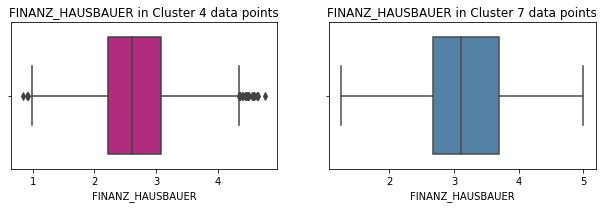

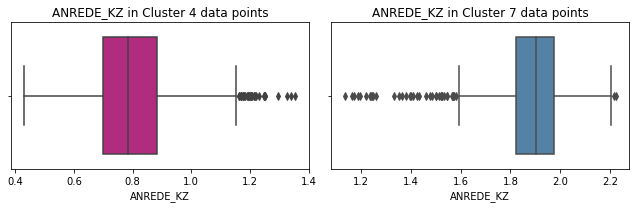

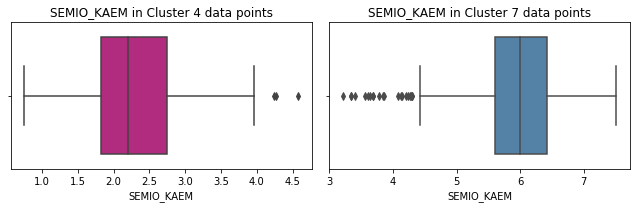

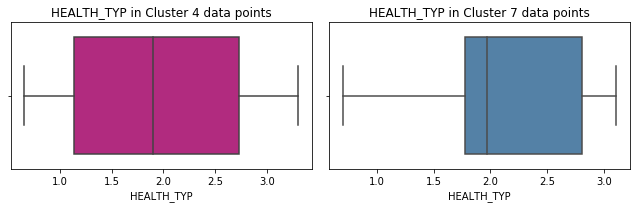

In [123]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

print('Taking 4 of the columns where Cluster 15\'s Principal Components have higher weights');

for column in ['FINANZ_HAUSBAUER', 'ANREDE_KZ', 'SEMIO_KAEM', 'HEALTH_TYP']:
    plt.figure(figsize=(9,3));
    plt.subplot(1,2,1);
    graph = sns.boxplot(x=column, data=clust_4_orig, color='mediumvioletred');
    plt.title(column + ' in Cluster 4 data points');
    
    plt.subplot(1,2,2);
    graph = sns.boxplot(x=column, data=clust_7_orig, color='steelblue');
    plt.title(column + ' in Cluster 7 data points');
    plt.tight_layout();

The above 4 attributes show very different different distributions for both clusters. However, one thing we can observe is that compared to distributions of Cluster #15 for Principal Components 30 and 45, these distributions have higher standard deviations from the norm for all attributes, as well as a larger distance between the adjacents. Let's look at these attributes and compare them for the two clusters:

- `FINANZ_HAUSBAUER` : This is one of the financial typology attributes, specifically standing for home ownership. For Cluster #4, the affinity is higher than it is for Cluster #7 (lower number is higher affinity and inversely).

- `ANREDE_KZ` : Gender, a very important classifier. This value actually varies between the two clusters, with data points within Cluster #4 classifying more frequently as Male, and those of #7 as Female. There is a lot of variation from the mean in both clusters, but the mean value differs.

- `SEMIO_KAEM` : One of the attributes which represent personality typology, this one is Combative attitude. There are actually a lot of other personality attributes that classify the two clusters, such as dominance and social-mindedness. For Semio-Kaem, Cluster #7 shows a lower affinity than it does for Cluster #4, with an average difference of almost 4 points.

- `HEALTH_TYP` : Health typology, this attribute represents how focused the person is on health and sanitation. This attribute is a little difficult to compare, because the average is actually almost the same for both, however, the lower percantile is lower for Cluster #4 than it is for #7. So, there are more people who are "critically reserved" about their health in #4, and almost none for #7.

The 4 attributes above show the main difference between the two clusters, and it is obvious what the distinguishing factor between the two is. As the attribute `ANREDE_KZ` feature shows, Cluster #7 represents female customers and #4 represents a subset of the male population. The other features also support this conclusion. Female customers could be less likely to be home owners if they are from traditional families, as the feature `FINANZ_HAUSBAUER` shows, and the personality attribute `SEMIO_KAEM` has a higher affinity for male customers, and lower for females (as they are less likely to have a combative attitude), and be less reserved about health and sanitary issues.

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

*The Clustering Analysis shows us that there are some visible trends between the Customers and the Demographic data. Although not all types of people identified within the Demographics have membership in the Customers dataset, there are some that have similar representation in both datasets. This includes Clusters #15, #10, and #8. These are also the clusters that have more than 10% membership in the customers dataset.*

*In the above analysis, we saw that Cluster #15 includes people who are in the Middle Class. Cluster #7 includes customers who are female. Both of these clusters can be valuable to the mail-order company for targetting, because they represent very specific parts of the demographic. Middle Class people are generally more likely to shop, as well as female women, so for the mail-order company, these segments of the population can be useful for targetting.*

*We also saw that there are certain features which show a larger liklihood that a person would shop, such as the attribute `KKK` (purchasing power in their region), `BALLRAUM` (distance to closest urban center), `FINANZTYP` (financial status), and `CJT_GESAMTTYP` (preferred method of purchasing). For two of these, we saw that they are part of the first principal component's higher weighted attributes, so by looking for clusters that are based on those clusters, we can get people who are more likely to be returning customers. We can do the same for other customers, by either finding the right principal components, or training a K Means clustering on all attributes.*

*Although I got good results, to improve my training model, I think that I could do 2 things differently.*

*1. I used a threshold of 10% missing values to decide whether to remove data points. After clustering I saw that there are a lot of points that fall very far from the mean values in the cluster, so removing those data points might have been more useful.*

*2. I used 120 Principal Components, which is still 60% of all features, but because there was an increase of almost 4% in explained variance by moving to 130 components, I think that doing so would have resulted in better clustering.*

*However, I still obtained meaningfull results, and through my clustering, can see that different segments of the population are properly separated into different clusters. For the mail order company, this shows that K Means clustering is an effective way to identify likely customers.*

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.